# Tutorial for using a Deep Sets model to find new open cluster members

This notebook walks through the steps for using a Deep Sets model to find additional open cluster members. It includes the data preparation, training of the model and a demonstration of some results. To minimize the runtime of this tutorial, we only show the steps for a single open cluster, NGC 1039, but the approach is the same for other clusters.

NGC 1039 is a well-behaved cluster, which allows for a demonstration of the method in favorable conditions. It is also embedded in a relatively small amount of field stars, which decreases the runtime.

First we import some basic packages and then we start with building the required datasets.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Building datasets

The main goal of this section is to build a training dataset for the model to train on. 

### Cluster

The first step is to create a `Cluster` object, which has attributes that relate to the properties of the open cluster. This class is useful for having all relevant cluster properties available in the same location. It requires a dictionary of attributes, which is printed in the next cell.

We need the following properties with corresponding (key):
- name (name)
- position (ra, dec)
- proper motions (pmra, pmdec) + errors (pmra_error, pmdec_error)
- parallax (parallax) + error (parallax_error)
- age (age)
- extinction at 550 nm (a0)
- distance (dist)

We can take download these properties from the Vizier catalogue provided by Cantat-Gaudin et al. (2020), who determined the age, extinction and distance with a neural network for ~2000 clusters. After this data has been download, we load the properties of a single cluster with the `load_cluster_parameters` function.

Note: Although the distance can be calculated with the parallax, we use explicit distances obtained by Cantat-Gaudin et al. (2020), as their neural network based the cluster distance on the distribution of the members in the colour-magnitude diagram (CMD). The CMD distribution constrains the distance modulus and thus the distance, which is helpful as the parallax is subject to systematic biases.

In [2]:
from gaia_oc_amd.data_preparation.query import query_vizier_catalog
from gaia_oc_amd.io import load_cluster_parameters
from gaia_oc_amd.data_preparation.cluster import Cluster

# Create a directory to store data in
data_save_dir = './data'
if not os.path.exists(data_save_dir):
    os.mkdir(data_save_dir)

# Query the Vizier catalogue to download cluster parameter data
cg20_cluster_params_catalog = 'J/A+A/640/A1/table1'
cg20_cluster_params_path = os.path.join(data_save_dir, 'cluster_parameters.csv')

if not os.path.exists(cg20_cluster_params_path):
    query_vizier_catalog(cg20_cluster_params_catalog, 
                         save_path=cg20_cluster_params_path,
                         columns=['Cluster', 'RA_ICRS', 'DE_ICRS', 'pmRA*', 'pmDE', 'e_pmRA*', 
                                   'e_pmDE', 'plx', 'e_plx','AgeNN', 'AVNN', 'DistPc'],
                         new_column_names={'Cluster': 'name', 
                                           'RA_ICRS': 'ra', 
                                           'DE_ICRS': 'dec', 
                                           'pmRA_': 'pmra',
                                           'pmDE': 'pmdec', 
                                           'e_pmRA_': 'pmra_error', 
                                           'e_pmDE': 'pmdec_error',
                                           'plx': 'parallax', 
                                           'e_plx': 'parallax_error', 
                                           'AgeNN': 'age', 
                                           'AVNN': 'a0', 
                                           'DistPc': 'dist'})

# Create a 'Cluster' object for NGC 1039
cluster_name = 'NGC_1039'
cluster_params = load_cluster_parameters(cg20_cluster_params_path, cluster_name)
cluster = Cluster(cluster_params)

print(cluster_params)

{'name': 'NGC_1039', 'ra': 40.531, 'dec': 42.722, 'pmra': 0.722, 'pmdec': -5.681, 'pmra_error': 0.292, 'pmdec_error': 0.325, 'parallax': 1.949, 'parallax_error': 0.105, 'age': 8.12, 'a0': 0.16, 'dist': 534.0}


### Cone search

Now that we have cluster properties, we can download sources from the Gaia archive that have similar properties and which therefore might be members of the cluster. We also want to include some informative non-members, such that the model can be trained with both positive and negative examples of open cluster members. 

To make large queries in the Gaia archive at https://gea.esac.esa.int/archive/, we require an account. The function that queries the Gaia archive expects a path to a file containing account credentials. A file can be made manually (username on the first line, password on the second) or by running the `create_gaia_credentials_file` function.

In [3]:
from gaia_oc_amd import create_gaia_credentials_file

# The gaia_credentials file should contain the username and password to log into the Gaia archive 
gaia_credentials_path = './gaia_credentials'

if not os.path.exists(gaia_credentials_path):
    create_gaia_credentials_file(save_path=gaia_credentials_path)

The `cone_search` function uses the `astroquery` package to download sources from the Gaia archive by performing a cone search on the cluster. For a source to be included, it must satisfy 3 conditions:
- Its sky position must be within a certain projected radius from the cluster mean (default is 50 pc)
- Its proper motion must be within a certain number sigma of the cluster mean (default is 10 sigma)
- Its parallax must be within a certain number sigma of the cluster mean (default is 10 sigma)

These conditions should ensure the inclusion of both candidates and (informative) non-members.

The `cone_search` function makes a `clusters_dir` folder if it does not exist yet and creates a subfolder with the same name as that of the `Cluster` object, which is the first argument provided to `cone_search`. In the cluster-specific subfolder, we save a 'cone.vot.gz' file which contains the cone sources in compressed votable format.

In [4]:
from gaia_oc_amd.data_preparation.query import cone_search

clusters_save_dir = os.path.join(data_save_dir, 'tutorial_clusters')
cluster_save_dir = os.path.join(clusters_save_dir, cluster.name)
cone_path = os.path.join(cluster_save_dir, 'cone.vot.gz')

if not os.path.exists(cone_path):
    cone_search(cluster=cluster, save_dir=clusters_save_dir, gaia_credentials_path=gaia_credentials_path,
                cone_radius=50., pm_sigmas=10., plx_sigmas=10.)

We load the cone sources as a `pandas` dataframe with the `load_cone` function. Next we use the `cone_preprocessing` function to apply the following pre-processing steps:
- Remove sources from the cone with no BP-RP colour.
- Subtract the parralax zero-point from the parallax of each source based on the recipe from Lindegren et al. (2021).
- Shift the sky position of some sources by a period if the cluster is located too close to a coordinate max value (such that sources for example don't have both l $\approx$ 0 and l $\approx$ 360, which results in bad plots).
- Add columns containing the uncertainties for the G, BP and RP magnitude, which are based on the expected error for a certain magnitude and number of observations.
- Give each source a default membership probability (PMemb) of 0%.

In [5]:
from gaia_oc_amd.io import load_cone
from gaia_oc_amd.data_preparation.cone_preprocessing import cone_preprocessing

cone = load_cone(cone_path)
cone = cone_preprocessing(cone)

print(cone.head())

          ra        dec  parallax      pmra     pmdec  parallax_error  \
0  42.722384  37.659274  1.711326  0.919694 -7.727432        0.019330   
1  42.928159  37.686667  1.181546 -0.810560 -4.362695        0.152563   
2  43.029085  37.741963  1.100328  0.085969 -2.860536        0.375754   
3  43.022323  37.756832  1.243795  3.371873 -6.940820        0.789722   
4  42.960466  37.718220  1.134414 -1.009200 -4.465808        0.877595   

   pmra_error  pmdec_error  parallax_pmra_corr  parallax_pmdec_corr  ...  \
0    0.019924     0.019975           -0.056008             0.035122  ...   
1    0.149933     0.142377            0.181485             0.182348  ...   
2    0.428449     0.391606            0.114544             0.171546  ...   
3    0.712740     0.619770            0.226694             0.126886  ...   
4    0.831654     0.773674            0.264343             0.064546  ...   

   astrometric_params_solved  phot_g_n_obs  phot_bp_n_obs  phot_rp_n_obs  \
0                         31

Now that we have preprocessed cone source data, we want to label each source as either a candidate member of the cluster or a non-member. To do this, we use a set of probable members of the cluster and its theoretical isochrone.

### Train members

To use this method to find open cluster members, we require a set of already established members. We use these members to determine which cone sources we label as candidates and to train the model to identify additional members. We can use the membership lists from Cantat-Gaudin et al. (2020), which were obtained with an unsupervised clustering algorithm. As with the cluster parameters, we can download the membership lists from Vizier.

In [6]:
cg20_members_catalogue = 'J/A+A/640/A1/nodup'
cg20_members_path = os.path.join(data_save_dir, 'cg20_members.csv')

if not os.path.exists(cg20_members_path):
    query_vizier_catalog(cg20_members_catalogue, 
                         save_path = cg20_members_path,
                         columns=['Cluster', 'GaiaDR2', 'proba'],
                         new_column_names={'Cluster': 'cluster', 'GaiaDR2': 'source_id', 'proba': 'PMemb'})

The file at 'cg20_members_path' now contains the source identities and corresponding membership probabilities of open cluster members for ~1400 clusters. To load the members of a single cluster, use the `load_members` function.

In [7]:
from gaia_oc_amd.io import load_members

cg20_members = load_members(cg20_members_path, cluster.name)

print(cg20_members.head())
print('Total CG20 members:', len(cg20_members))
print('Mean member probability:', cg20_members['PMemb'].mean())

            source_id  PMemb
0  335503161330544128    1.0
1  336037386542471552    1.0
2  336075869449366016    0.9
3  336080817251680640    0.9
4  336452177304411264    1.0
Total CG20 members: 555
Mean member probability: 0.9524324324324325


As we want to train our model on sources that are very likely to be members, we determine the source identities of sources that have a 100% probability of being a member. This leaves us with 394 highly probable members.

In [8]:
prob_threshold = 1.0
train_members = cg20_members[cg20_members['PMemb'] >= prob_threshold]

print('Number of train members:', len(train_members))

Number of train members: 394


Next we use the `member_set` function to crossmatch these identities with our cone search sources to obtain their high precision astrometric and photometric measurements from Gaia DR3. 

In [9]:
from gaia_oc_amd.data_preparation.source_sets import member_set

# Construct the member set
train_members = member_set(cone, train_members['source_id'], train_members['PMemb'])

print(train_members.head())

            source_id  PMemb         ra        dec  parallax      pmra  \
0  335503161330544128    1.0  39.259925  41.371980  1.814323  0.761164   
1  336037386542471552    1.0  41.864928  41.076721  1.908025  0.887928   
2  336452177304411264    1.0  42.314399  41.747380  2.084253  0.877333   
3  336669983686095616    1.0  40.595312  40.736147  2.087504  0.809097   
4  336689087700520832    1.0  41.341907  40.947110  2.028403  1.053945   

      pmdec  parallax_error  pmra_error  pmdec_error  ...    ecl_lat  \
0 -6.122003        0.040901    0.044062     0.043684  ...  24.676792   
1 -6.021880        0.037635    0.041517     0.036651  ...  23.749069   
2 -5.356935        0.058820    0.063158     0.058205  ...  24.274813   
3 -5.875288        0.035250    0.041911     0.034926  ...  23.740793   
4 -5.453647        0.019758    0.018109     0.017377  ...  23.754743   

   astrometric_params_solved  phot_g_n_obs  phot_bp_n_obs  phot_rp_n_obs  \
0                         31           206    

Before moving on, let's take a look at the distribution of these members with the `plot_sources` function. This function makes four plots to show the distribution of sources in sky position, proper motion, parallax and the CMD. As will be shown later, the `plot_sources` function has a number of options, such as adding field stars to the plots or adding a second member set for comparison.

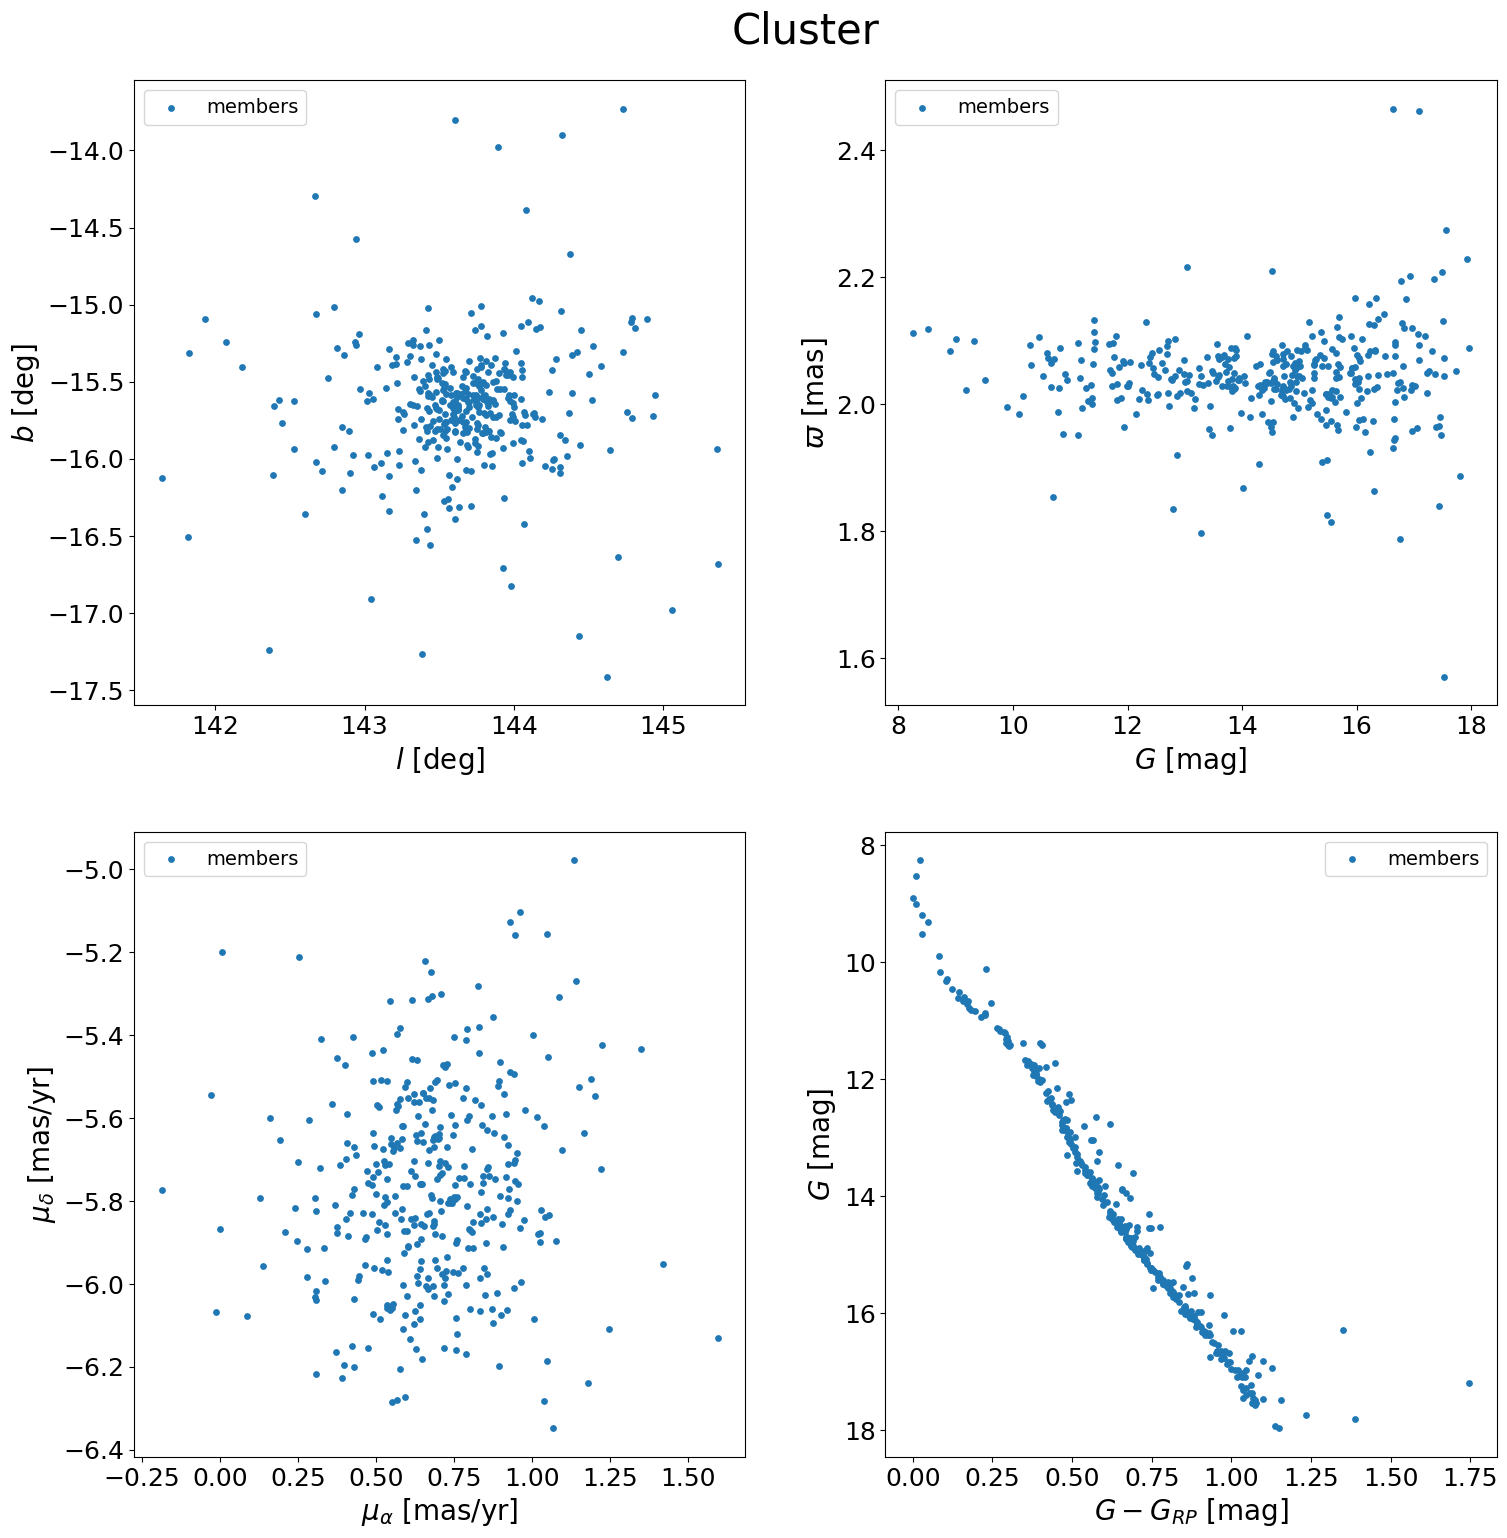

In [10]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_sources

plot_sources(train_members)

### Isochrone

To determine the membership status of a source, our method takes source's location in the CMD with respect to the isochrone into account. Therefore we need to download the isochrone corresponding to the age of the cluster (we assume a default metal fraction of $Z=0.0152$). For this we use the `query_isochrone` function, which downloads isochrones from http://stev.oapd.inaf.it/cgi-bin/cmd.

In [11]:
from gaia_oc_amd.data_preparation.query import query_isochrone
from gaia_oc_amd.io import load_isochrone
from gaia_oc_amd.data_preparation.isochrone_preprocessing import isochrone_preprocessing

print('Cluster log(age):', cluster.age)
isochrone_path = os.path.join(data_save_dir, 'isochrones.dat')

if not os.path.exists(isochrone_path):
    query_isochrone(isochrone_path, 
                    log_age_min=cluster.age, 
                    log_age_max=cluster.age, 
                    log_age_step=0., 
                    metal_frac=0.0152)

Cluster log(age): 8.12


We can subsequently load the isochrone of the desired age with `load_isochrone`.

In [12]:
isochrone = load_isochrone(isochrone_path, cluster.age)
print(isochrone.head())

         Zini       MH   logAge      Mini   int_IMF   Mass   logL   logTe  \
69555  0.0152  0.01508  8.12005  0.090000  1.081690  0.090 -2.845  3.3985   
69556  0.0152  0.01508  8.12005  0.093918  1.118196  0.094 -2.813  3.4033   
69557  0.0152  0.01508  8.12005  0.100000  1.171106  0.100 -2.761  3.4110   
69558  0.0152  0.01508  8.12005  0.102458  1.191316  0.102 -2.744  3.4134   
69559  0.0152  0.01508  8.12005  0.112636  1.268753  0.113 -2.671  3.4236   

        logg  label  ...       Y        Xc        Xn        Xo  Cexcess  \
69555  4.784      0  ...  0.2755  0.002746  0.000741  0.006719     -1.0   
69556  4.789      0  ...  0.2755  0.002746  0.000741  0.006719     -1.0   
69557  4.795      0  ...  0.2755  0.002746  0.000741  0.006719     -1.0   
69558  4.798      0  ...  0.2755  0.002746  0.000741  0.006719     -1.0   
69559  4.807      0  ...  0.2755  0.002746  0.000741  0.006719     -1.0   

             Z  mbolmag  phot_g_mean_mag  G_BPmag  G_RPmag  
69555  0.01527   11.883  

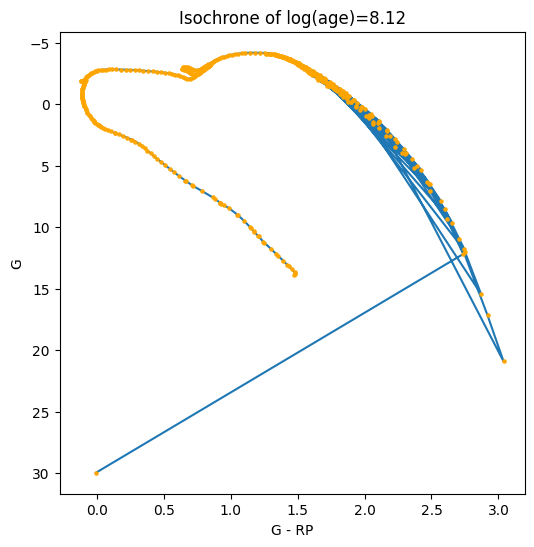

In [13]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.plot(isochrone['phot_g_mean_mag'] - isochrone['G_RPmag'], isochrone['phot_g_mean_mag'], zorder=-1)
ax.scatter(isochrone['phot_g_mean_mag'] - isochrone['G_RPmag'], isochrone['phot_g_mean_mag'], s=5, c='orange', zorder=0)
ax.invert_yaxis()
ax.set_xlabel('G - RP')
ax.set_ylabel('G')
ax.set_title(f'Isochrone of log(age)={cluster.age}')
plt.show()

The `isochrone_preprocessing` function corrects the isochrone magnitudes for the cluster distance and the interstellar extinction. It also has the option the exclude data beyond a certian evolutionary stage. 

One of the features we attribute sources to determine their membership is the vector between a source and the closest isochrone point. The isochrone is made up of discrete points, which represent stars of different initial masses, but these are not evenly distributed in the CMD. To approximate the continuous evolutionary track, we provide the option to linearly interpolate between two points that are farther apart than a certain threshold. As linear interpolation is not suitable for the older evolutionary stages, we also have an 'oldest_stage_to_interpolate' keyword argument.

In [14]:
print('Cluster distance:', cluster.dist, 'pc')
print('Cluster extinction:', cluster.a0)

processed_isochrone = isochrone_preprocessing(isochrone, cluster.dist, colour='g_rp', a0=cluster.a0, 
                                              oldest_stage=7, interpolation_density=5., 
                                              oldest_stage_to_interpolate=5)
old_isochrone = isochrone_preprocessing(isochrone, cluster.dist, colour='g_rp', a0=cluster.a0, 
                                        oldest_stage=7, interpolation_density=0., 
                                        oldest_stage_to_interpolate=5)

print(processed_isochrone.head())

Cluster distance: 534.0 pc
Cluster extinction: 0.16
       g_rp  phot_g_mean_mag
0  1.506483        22.696092
1  1.507605        22.615246
2  1.507803        22.487496
3  1.507865        22.443574
4  1.497499        22.307243


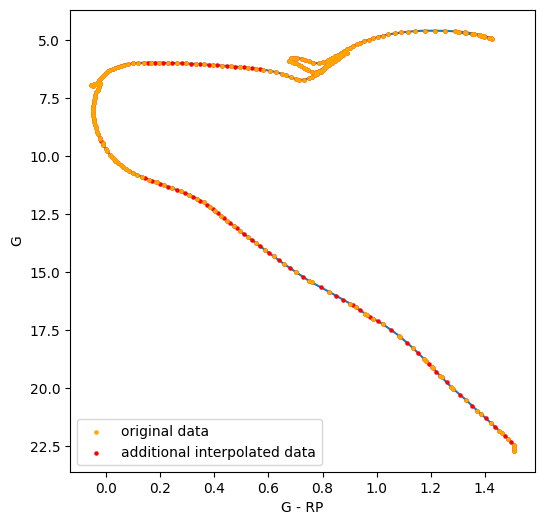

In [15]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
ax.plot(processed_isochrone['g_rp'], processed_isochrone['phot_g_mean_mag'], zorder=-1)
ax.scatter(old_isochrone['g_rp'], old_isochrone['phot_g_mean_mag'], 
           s=5, c='orange', zorder=1, label='original data')
ax.scatter(processed_isochrone['g_rp'], processed_isochrone['phot_g_mean_mag'], 
           s=5, c='red', zorder=0, label='additional interpolated data')
ax.invert_yaxis()
ax.set_xlabel('G - RP')
ax.set_ylabel('G')
ax.legend()
plt.show()

### Labeling cone sources

With the train members and isochrone, we can now label the cone sources as either candidate or non-member. This is done by giving the `Cluster` object all the necessary information relating to the candidate selection, which is then passed to the `candidate_and_non_members_set` function to separate the cone sources.

First we update the astrometric parameters of the cluster based on our training members. This is not strictly necessary, but updating the parameters ensures that the non members and candidates conform to our member distribution. 

Second, we provide the parameters used by the candidate selection algorithm. The `set_candidate_selection_parameters` function requires the training members, the isochrone data and a number of keyword arguments that tune the 'strictness' of the candidate selection in certain dimensions. 

In order for sources to be selected as candidates, they need to satisfy three conditions, relating to their proper motion, parallax, G magnitude and G-RP colour. In words, sources that do not deviate significantly from (i) the mean cluster proper motion, (ii) the mean cluster parallax and (iii) the isochrone are selected as candidate.

In [16]:
from gaia_oc_amd.data_preparation.source_sets import candidate_and_non_member_set

# Update the cluster parameters based on the members
cluster.update_astrometric_parameters(train_members)

# Set cluster parameters that are relevant for the candidate selection and training features
cluster.set_candidate_selection_parameters(train_members, processed_isochrone, colour='g_rp', 
                                           source_error_weight=3., pm_error_weight=3., r_max_margin=15., 
                                           zpt_error=0.015, delta_c0=0.3, delta_g0=2.4, c_margin=0.1, 
                                           g_margin=0.8, member_fraction=0.90, alpha=0.95)

# Construct the candidate and non-member set
candidates, non_members = candidate_and_non_member_set(cone, cluster)

print('Members:', len(train_members))
print('Candidates:', len(candidates))
print('Non members:', len(non_members))

Members: 374
Candidates: 18343
Non members: 26455


It is possible that cone sources are both present in the CG20 membership list and selected as non-member by our candidate selection, i.e. they are labeled as both member and non-member. Blue stragglers, for example, are sources which do not follow the isochrone, but have proper motions and parallaxes which suggest they are likely part of the cluster. As this is obviously confusing for the model trying to determine membership, we discard these sources from the training members and non-members and add them to the candidates.

In [17]:
from gaia_oc_amd.data_preparation.source_sets import get_duplicate_sources

dubious_members = get_duplicate_sources(train_members, non_members, keep='last')

print('Number of dubious sources:', len(dubious_members))

if len(dubious_members) > 0:
    train_members = train_members[~train_members['source_id'].isin(dubious_members['source_id'])].copy()
    non_members = non_members[~non_members['source_id'].isin(dubious_members['source_id'])].copy()
    candidates = pd.concat((candidates, dubious_members))

Number of dubious sources: 5


Below, we plot the distribution of the members, candidates and non-members with the `plot_sources` function. 

The main components of the candidate selection are the 'maximum separation delta' which determine the boundaries between candidates and non-members for sources with negligible errors. These are visualized by the red dashed lines in the plot below. Sources that are further than a certain number of standard deviations (source_error_weight=3) outside these boundaries are not selected as candidate. 

For showing the boundaries, as well as the isochrone, the `plot_sources` function needs to be supplied with a `Cluster` object for which the candidate selection parameters have been set.

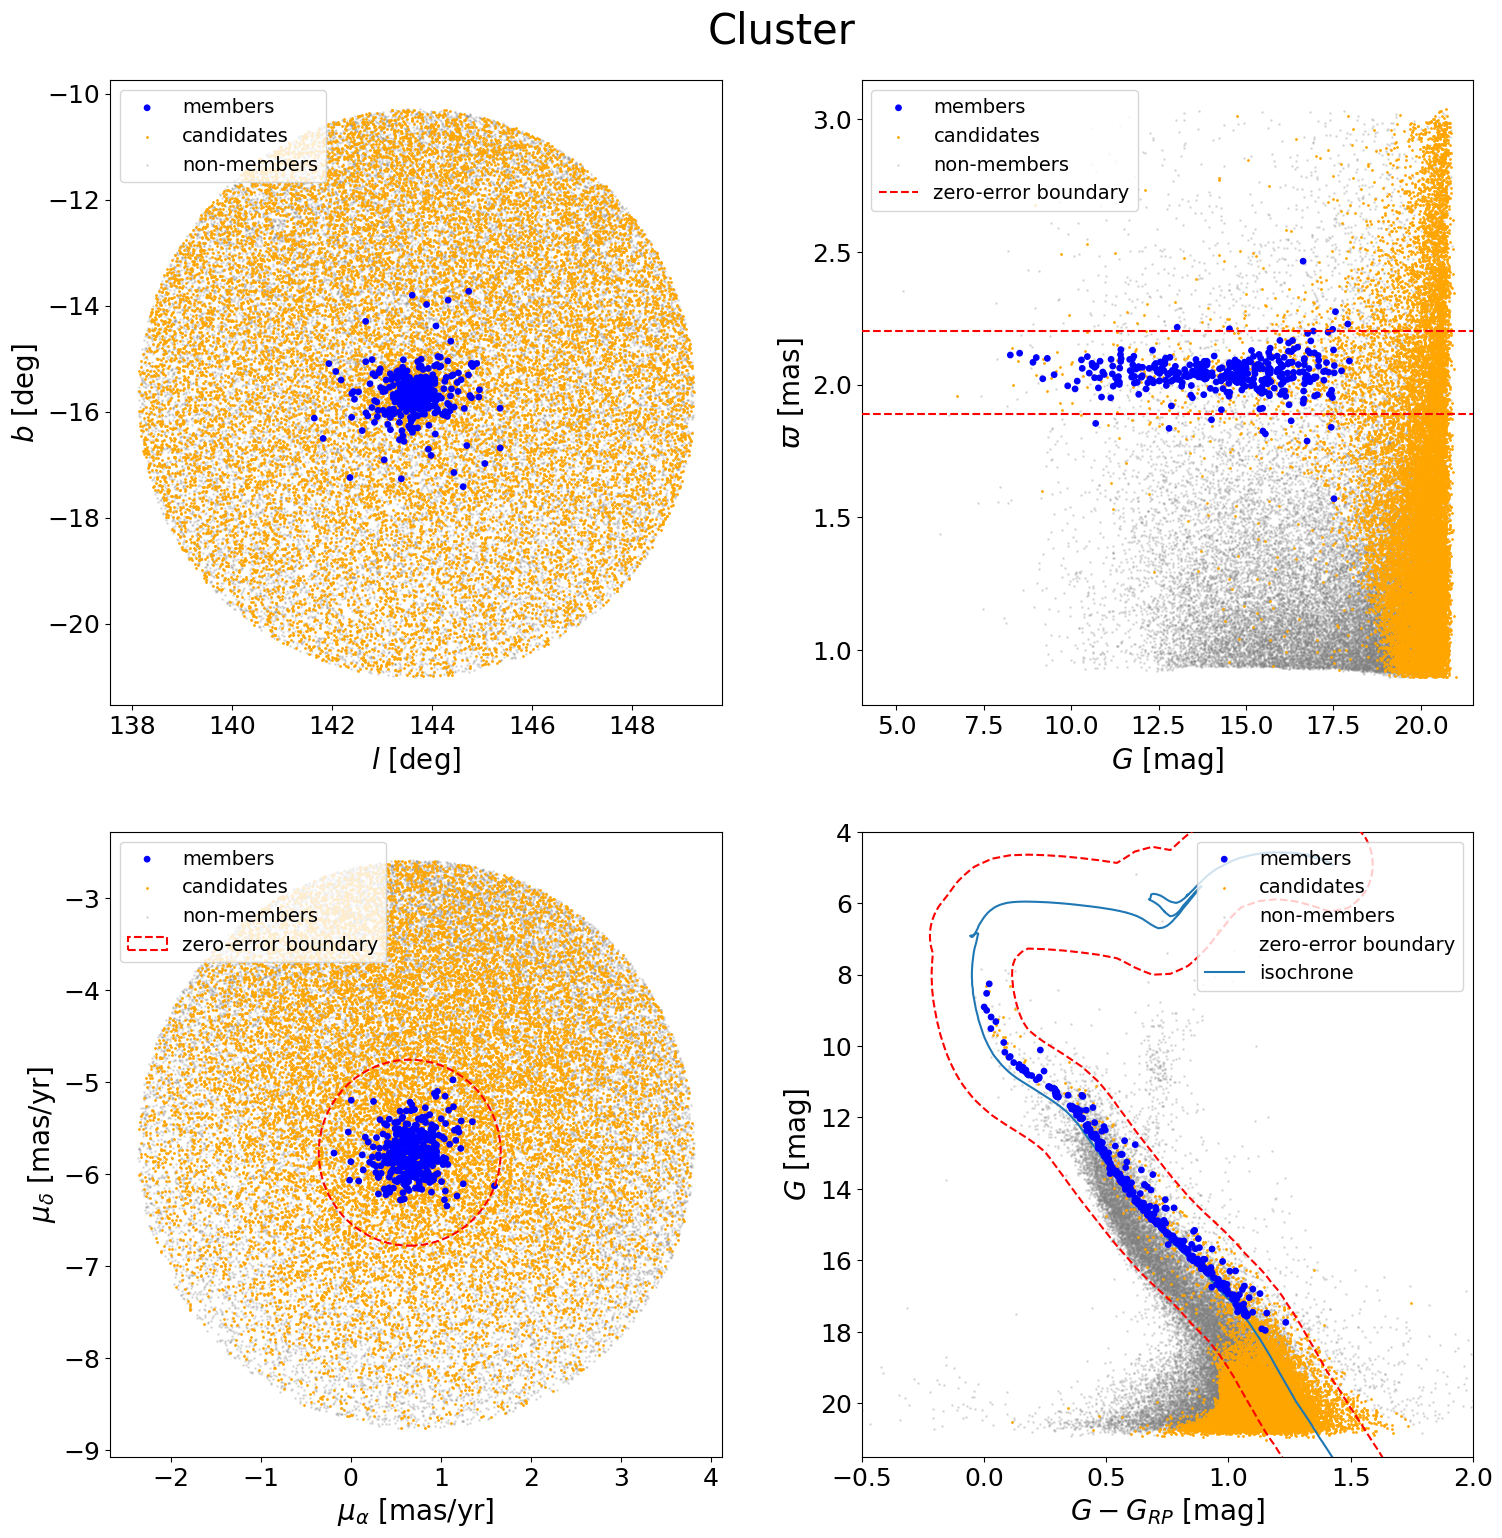

In [18]:
limits = {'phot_g_mean_mag': [4, 21.5], 'g_rp': [-0.5, 2.0]}

plot_sources(train_members, colour='g_rp', candidates=candidates, field_sources=non_members, 
             plot_type='candidates', cluster=cluster, show_boundaries=True, show_isochrone=True, 
             limits=limits)

### Features

To teach the model to differentiate members from non-members, we supply all sources with with a number of features that relate to their likelihood of being a member. The feature functions expect a row from a sources dataframe as input and outputs the feature value. We use the `add_columns` function to apply the feature functions to multiple dataframes.

The five features are:
- `f_r`, separation from the cluster mean in sky position
- `f_pm`, separation from the cluster mean in proper motion
- `f_plx`, separation from the cluster mean in parallax
- `f_c`, colour component of the separation from the isochrone
- `f_g`, G magnitude component of the separation from the isochrone

In [19]:
from gaia_oc_amd.data_preparation.features import add_features

add_features([train_members, candidates, non_members], cluster)

print(train_members[['f_r', 'f_pm', 'f_plx', 'f_c', 'f_g']][:5])

         f_r      f_pm     f_plx       f_c       f_g
0  15.108940  0.367528 -0.224165  0.006825 -0.118887
1  17.968820  0.343097 -0.130462 -0.017257  0.038971
2  15.461961  0.469434  0.045766 -0.004767  0.114507
3  18.419418  0.186736  0.049016 -0.000545  0.092297
4  17.470072  0.509515 -0.010085 -0.014421  0.168377


 We can visualize the features of a certain candidate with the `show_features_source_id` keyword.

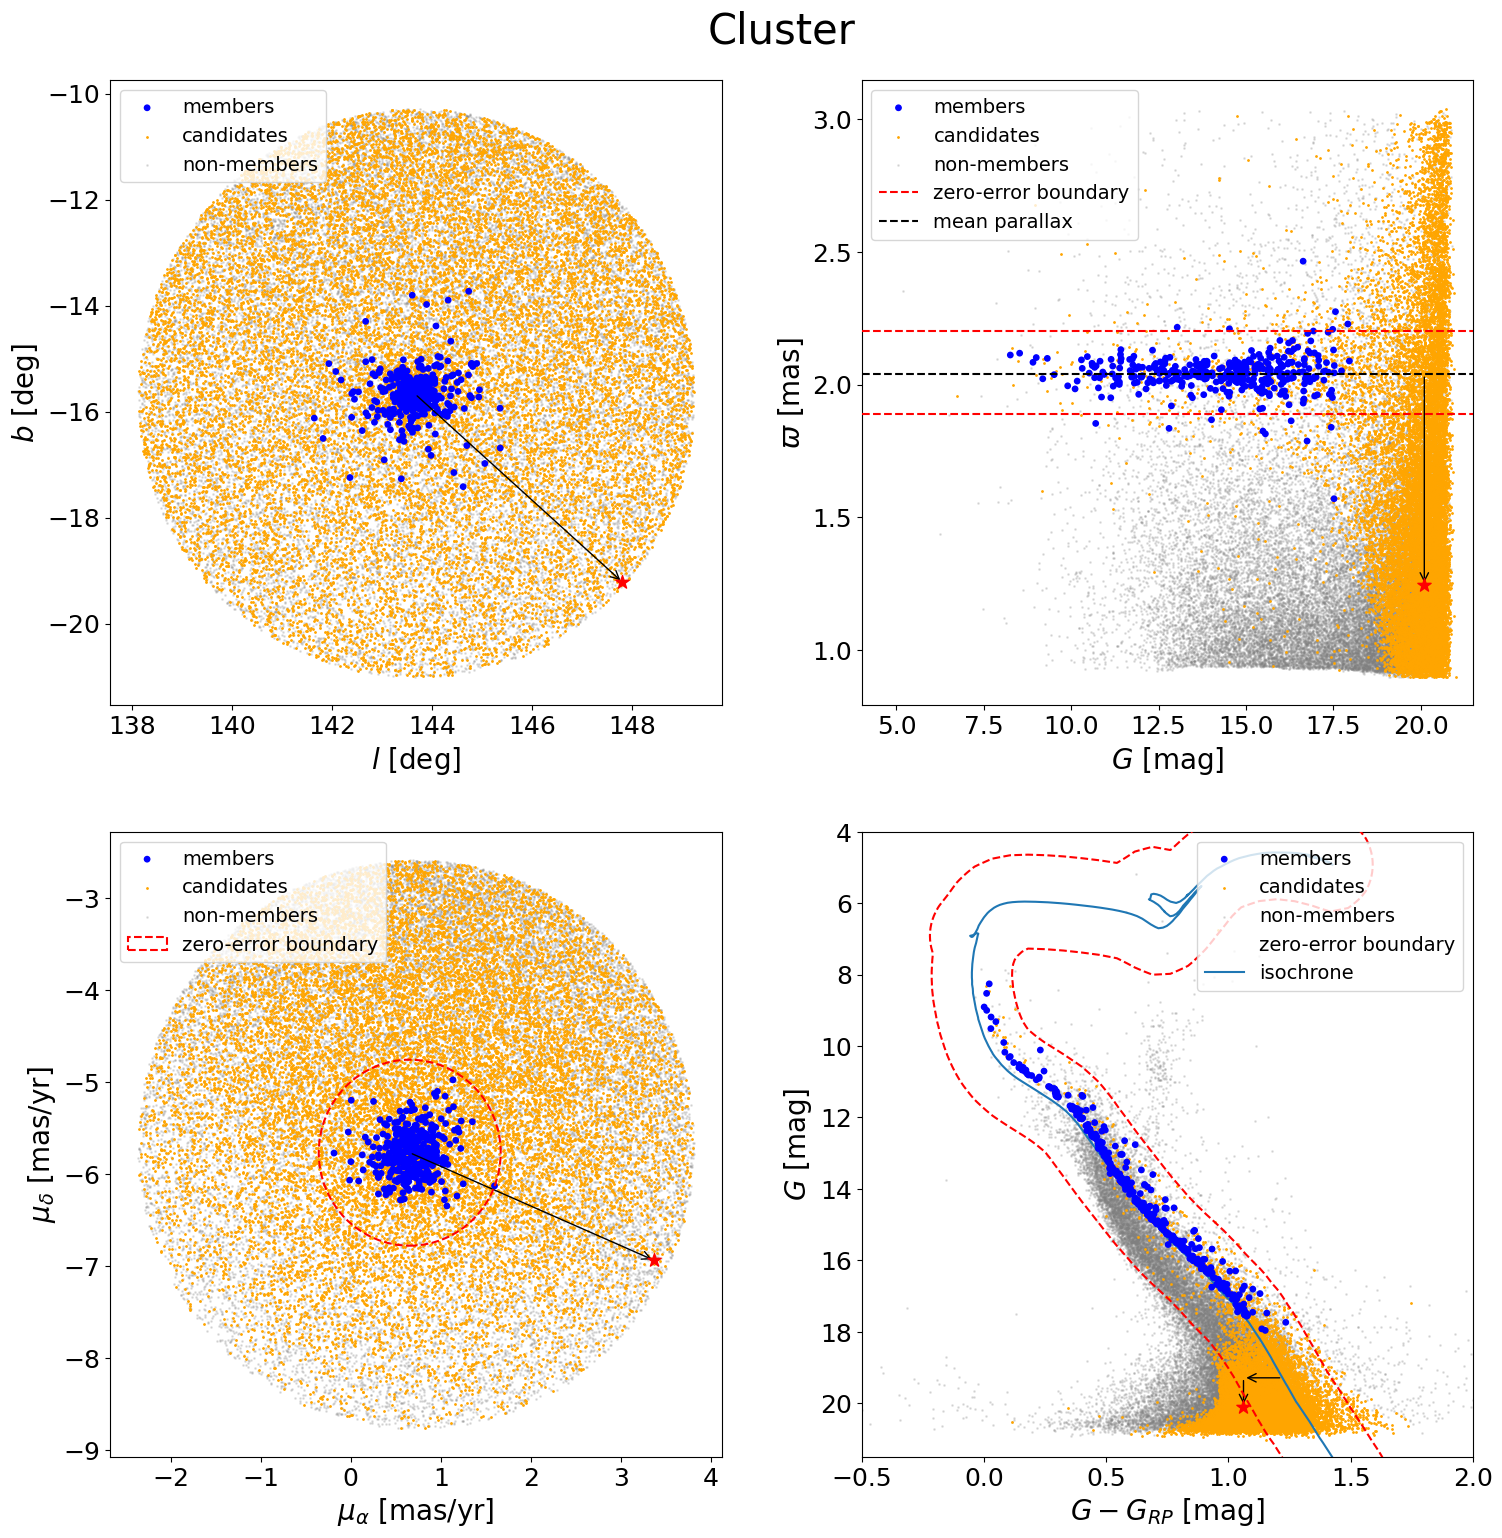

In [20]:
plot_sources(train_members, colour='g_rp', candidates=candidates, field_sources=non_members, 
             plot_type='candidates', cluster=cluster, show_features_source_id=candidates['source_id'].values[0], 
             show_boundaries=True, show_isochrone=True, limits=limits)

### Saving and loading data

To store the cluster parameters and the various sets, we can use the `save_cluster` and `save_sets` functions. To load them, use the `load_cluster` and `load_sets` function.

In [21]:
from gaia_oc_amd.io import save_sets, save_cluster

save_cluster(cluster_save_dir, cluster)
save_sets(cluster_save_dir, train_members, candidates, non_members)

# from gaia_oc_amd.io import load_sets, load_cluster
#
# cluster_params = load_cluster(cluster_dir)
# cluster = Cluster(cluster_params)
# train_members, candidates, non_members, _ = load_sets(cluster_dir)

### Creating a training dataset

With the members and non-members, we create a training dataset with the `MultiClusterDeepSetsDataset` class. This function uses a list of cluster names to load the members, non-members and candidates from respective csv files in `clusters_dir\cluster_name`, which are saved there by `save_sets`. Each instance in the training set consist of a tuple containing the model input and a label. 

The model input is made up of a source we want to classify (either a member or a non-member) and a support set (a random set of members). The model is trained to recognize when the source-to-classify is similar enough to the positive examples in the support set, i.e. to members. 

When `MultiClusterDeepSetsDataset` is initialized, the features are first standardized, i.e we subtract the mean and divide by the standard deviation. We calculate the means and standard deviations outside the function so we do not need to calculate them again when we create a dataset for an optional validation set. The values of `n_pos_duplicates` and `neg_pos_ratio` determine, respectively, how many times each member is used as a source-to-classify and how many non-members (of the same cluster) should be included for every member. Since we only have 374 members and 26461 non-members, we only include 374 * 2 * 5 / 26461 * 100 = 14% of the non-members in our dataset with these settings. The `n_min_members` keyword makes sure that only clusters with more than a certain number of members are included in the dataset. This value must also be larger than the size of the support set.

The `MultiClusterDeepSetsDataset` is a child class of PyTorch's `Dataset` class, which can be supplied to a `DataLoader` to create a batched dataset, which is shuffled before every epoch.

In [22]:
from gaia_oc_amd.data_preparation.datasets import property_mean_and_std, MultiClusterDeepSetsDataset
from torch.utils.data import DataLoader

# data params
cluster_names = [cluster_name]
source_features = ['f_r', 'f_pm', 'f_plx', 'f_c', 'f_g']
cluster_features = ['a0', 'age', 'parallax']

means, stds = property_mean_and_std(clusters_save_dir, cluster_names, source_features, cluster_features)

train_dataset = DataLoader(MultiClusterDeepSetsDataset(clusters_save_dir, cluster_names, source_features,
                                                       source_feature_means=means['source'], 
                                                       source_feature_stds=stds['source'],
                                                       cluster_feature_names=cluster_features,
                                                       cluster_feature_means=means['cluster'],
                                                       cluster_feature_stds=stds['cluster'],
                                                       n_pos_duplicates=2,
                                                       neg_pos_ratio=5,
                                                       n_min_members=15,
                                                       size_support_set=10), 
                           batch_size=32, shuffle=True)

Creating cluster(s) dataset: 100%|████████████████| 1/1 [00:00<00:00,  3.18it/s]


The shape of the model input is a [batch $\times$ size_support_set $\times$ $2M$] tensor, where $M$ the number of features used for training. The factor 2 is there because the features of the source-to-classify are concatenated to the features of each support set source.

The label of each dataset instance indicates the class of the source-to-classify, with [0, 1] for member and [1, 0] for non-member.

In [23]:
model_input, label = next(iter(train_dataset))

print('Input shape:', model_input.shape)
print('Model input:', model_input[0])
print('Label:', label[0])

Input shape: torch.Size([32, 10, 13])
Model input: tensor([[ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.5553, -2.3072,  1.3382, -1.1691,  1.2027],
        [ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.4472, -2.3946,  1.4561, -1.3428,  0.9245],
        [ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.0325, -2.0812,  1.1718, -1.0605,  0.9038],
        [ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.0773, -2.2932,  1.4360, -0.8098,  0.8761],
        [ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.2416, -2.1603,  1.4374, -0.8088,  0.8646],
        [ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.1009, -2.2761,  1.3610, -0.9414,  0.7603],
        [ 0.5044, -0.7031, -0.7931, -0.2519,  0.3056,  0.0000,  0.0000,  0.0000,
         -2.3197, -1.7607,  1.7085, -0.9871,  0.8963

## Training the model

Now that we have the datasets, we can train the model. We start by instantiating a Deep Sets model, developed by Zaheer et al. (2017), where the 5 in `D5` indicates the number of permutation equivariant layers in the model, for which 5 was used by Oladosu et al. (2021).

We use 64 nodes in the hidden layers and a 'mean' pooling function. The `x_dim` is determined by the number of features and `out_dim` represents the number of classes (member and non-member).

In [24]:
from gaia_oc_amd.machine_learning.deepsets_zaheer import D5

# model params
hidden_size = 64

model = D5(hidden_size, x_dim=2 * len(source_features) + len(cluster_features), pool='mean', out_dim=2)

Training is done with the `train_model` function, where we train here for a maximum of 20 epochs, use a learning rate `lr` of $10^{-5}$ and an l2 regularization weight `l2` of $10^{-5}$ as well. The `weight_imbalance`, used to mitigate an imbalanced dataset, is the factor by which the loss is multiplied when classifying members. A higher value thus increases the penalty for failing to classify members, but can bias the model to select some non-members as members as well. During training, we keep track of the F1 score to estimate the performance. The model parameters are saved in the directory given by `model_save_dir`. A validation set can also be created in the same way as the training set and provided to `train_model`.

In [25]:
from gaia_oc_amd.machine_learning.training import train_model

model_dir = './tutorial_model'

metrics = train_model(model, model_dir, train_dataset, val_dataset=None, 
                      num_epochs=20, lr=1e-5, l2=1e-5, weight_imbalance=5.)

train epoch 0: 100%|████| 139/139 [00:00<00:00, 227.24it/s, loss=34.8, f1=44.5%]


train epoch 1: 100%|████| 139/139 [00:00<00:00, 229.53it/s, loss=29.9, f1=78.3%]


train epoch 2: 100%|████| 139/139 [00:00<00:00, 252.97it/s, loss=23.6, f1=86.8%]


train epoch 3: 100%|████| 139/139 [00:00<00:00, 203.53it/s, loss=17.2, f1=90.7%]


train epoch 4: 100%|████| 139/139 [00:00<00:00, 201.46it/s, loss=11.2, f1=93.5%]


train epoch 5: 100%|███████| 139/139 [00:00<00:00, 238.86it/s, loss=7, f1=94.7%]


train epoch 6: 100%|████| 139/139 [00:00<00:00, 245.76it/s, loss=4.12, f1=96.5%]


train epoch 7: 100%|████| 139/139 [00:00<00:00, 235.74it/s, loss=2.55, f1=97.4%]


train epoch 8: 100%|█████| 139/139 [00:00<00:00, 249.08it/s, loss=1.7, f1=97.5%]


train epoch 9: 100%|████| 139/139 [00:00<00:00, 237.95it/s, loss=1.25, f1=97.8%]


train epoch 10: 100%|██████| 139/139 [00:00<00:00, 250.13it/s, loss=1, f1=97.9%]


train epoch 11: 100%|██| 139/139 [00:00<00:00, 249.68it/s, loss=0.842, f1=98.1%]


train epoch 12: 100%|███| 139/139 [00:00<00:00, 259.97it/s, loss=0.71, f1=98.3%]


train epoch 13: 100%|██| 139/139 [00:00<00:00, 243.83it/s, loss=0.704, f1=98.4%]


train epoch 14: 100%|███| 139/139 [00:00<00:00, 248.70it/s, loss=0.66, f1=98.5%]


train epoch 15: 100%|██| 139/139 [00:00<00:00, 244.56it/s, loss=0.692, f1=98.5%]


train epoch 16: 100%|██| 139/139 [00:00<00:00, 271.87it/s, loss=0.597, f1=98.5%]


train epoch 17: 100%|██| 139/139 [00:00<00:00, 272.71it/s, loss=0.528, f1=98.7%]


train epoch 18: 100%|███| 139/139 [00:00<00:00, 268.06it/s, loss=0.54, f1=98.8%]


train epoch 19: 100%|██| 139/139 [00:00<00:00, 260.22it/s, loss=0.503, f1=98.7%]


We can visualize the training process by plotting the evolution of the loss value and a number of metrics. At the end of training, the members and non-members are classified with near perfect accuracy.

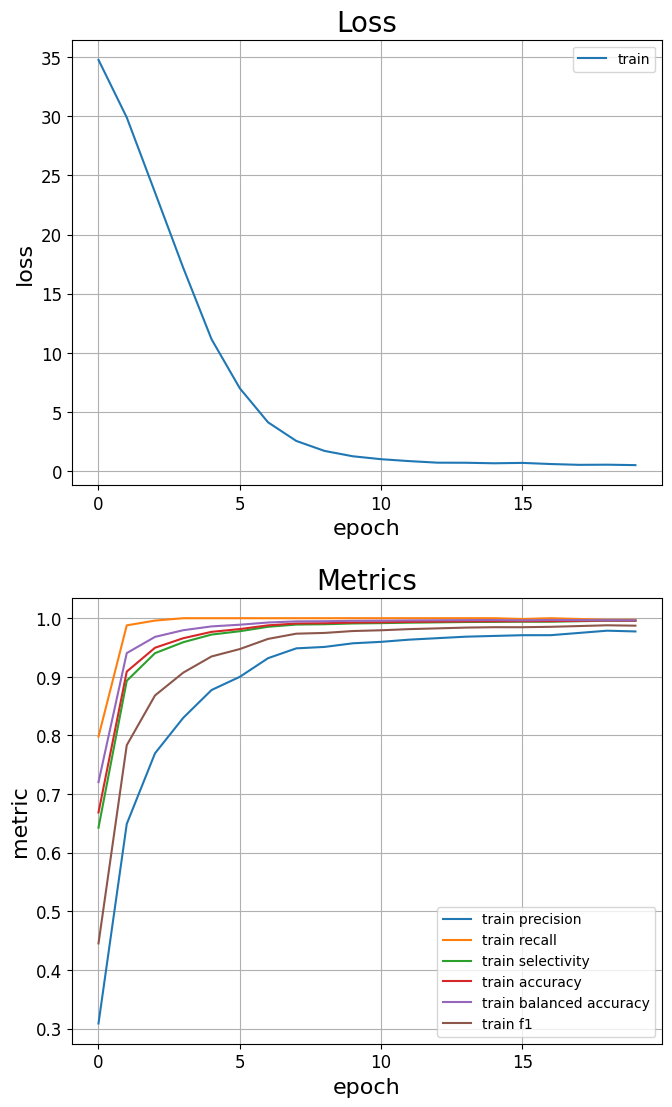

In [26]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_metrics

plot_metrics(metrics, model_dir)

### Evaluating candidates

Once the model is trained, we can use it to evaluate the candidates. Alternatively, we use the pretrained model which has been trained on ~100 clusters to display optimal results.

To take the errors in the astrometric and photometric properties of the candidates into account, we resample the training features of each candidate a number of times, based on the uncertainties and correlations of its properties. The smaller the errors of the candidate properties, the more compact the sample distribution will be and the more similar the membership predictions for the samples of that candidate. We interpret the fraction of samples that were identified by the model as member as the candidate's membership probability. Here, 'identified as member' means that the model outputs a softmax probability of greater than 50% for the member class.

The `calculate_candidate_probs` function first generates the candidate samples and then creates a deep sets dataset for each sample. The training features also need to be re-calculated, as the properties on which they depend have different values. Each candidate is also given a new support set for each sample. From the sample predictions (i.e. member=True/False), the membership probabilities are calculated.

The probabilities are saved in the candidate csv file.

Depending on the number of candidates and samples, this evaluation process may take only a few seconds or up to an hour for $\sim$$10^{6}$ candidates. By setting the 'fast_mode' argument to True, we use a 4x faster, but more memory intensive, method for recalculating the candidate features.

In [27]:
from gaia_oc_amd.candidate_evaluation.membership_probability import calculate_candidate_probs
from gaia_oc_amd.evaluate_clusters import PRETRAINED_MODEL_DIR
from gaia_oc_amd.io import load_model

# model_dir = PRETRAINED_MODEL_DIR

# evaluation params
n_samples = 100
fast_mode = True

calculate_candidate_probs(cluster_save_dir, model_dir, n_samples=n_samples, 
                          fast_mode=fast_mode)

Evaluating candidate samples: 100%|███████████| 100/100 [01:08<00:00,  1.45it/s]


## Results

With the membership probabilities of the candidates determined, we can check their distribution and see how they compare against another member set. We load the candidates again, which now have the memberhip probabilities calculated by our method.

We can plot the evaluated candidates above a certain probability with the `plot_sources` function. Here, we take the subset of members with a membership probability of 80% or higher and treat the other candidates to the non-members.

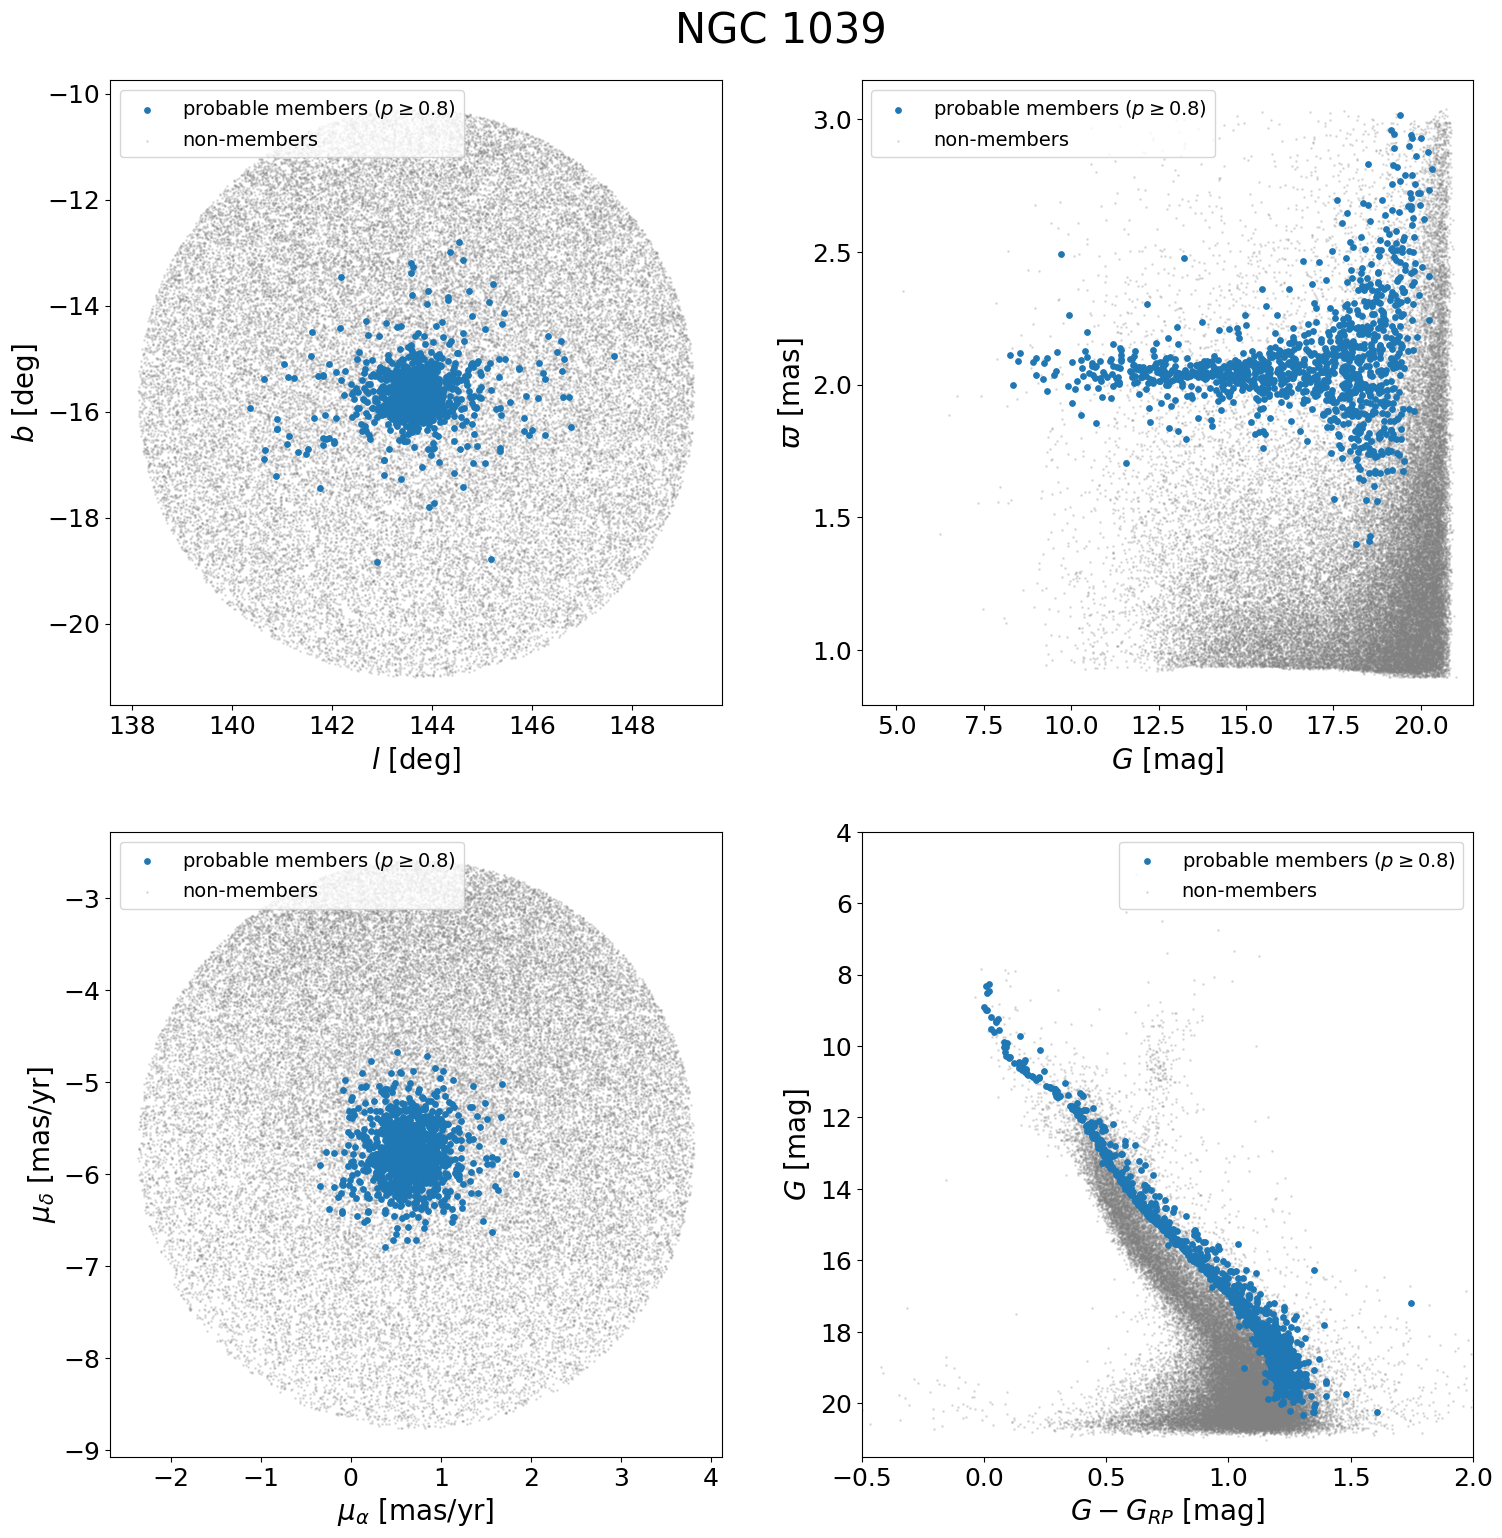

In [28]:
from gaia_oc_amd.io import load_sets

_, candidates, _, _ = load_sets(cluster_save_dir)

prob_threshold = 0.8
member_candidates = candidates[candidates['PMemb'] >= prob_threshold]
non_member_candidates = pd.concat((non_members, candidates[candidates['PMemb'] < prob_threshold]))

plot_title = f'{cluster.name}'.replace('_', ' ')

plot_sources(member_candidates, field_sources=non_member_candidates,
             members_label=f'probable members ($p\\geq${prob_threshold})', 
             title=plot_title, limits=limits)

### Compare members

If available, we can also define some 'comparison' members, which we can use to compare against the members obtained by the DS model. Here we use membership lists from Tarricq et al. (2022).

In [29]:
t22_members_catalogue = 'J/A+A/659/A59/table2'
t22_members_path = os.path.join(data_save_dir, 't22_members.csv')

if not os.path.exists(t22_members_path):
    query_vizier_catalog(t22_members_catalogue, 
                         save_path = t22_members_path,
                         columns=['Cluster', 'GaiaEDR3', 'Proba'],
                         new_column_names={'Cluster': 'cluster', 'GaiaEDR3': 'source_id', 'Proba': 'PMemb'})

comparison_members = load_members(t22_members_path, cluster.name)

comparison_member_ids = comparison_members['source_id']
comparison_member_probs = comparison_members['PMemb']

comparison_members = member_set(cone, comparison_member_ids, comparison_member_probs)

print('Total comparison members:', len(comparison_members))
print('Mean comparison member probability:', comparison_member_probs.mean())

Total comparison members: 774
Mean comparison member probability: 0.8410472541507024


We can compare the member sets in a number of different ways, including:

- A density profile, which shows how well a King model fits the projected density distribution of candidates with a membership probability of 10% or higher (this plot works better if the model is not trained on the sky position radius `f_r`).
- A mass segregation profile, which shows the degree to which the distribution of the $N_{MST}$ most massive members is more clustered than a distribution of $N_{MST}$ random members. The tightness of the clustering is measured with the length of the minimum spanning tree, which connects the members in projected sky position coordinates. A value higher than 1 means that the $N_{MST}$ most massive members are more tightly clustered.
- A venn diagram, showing the overlap between the different member sets for members above a 10%, 50% and 90% probability threshold. Red are comparison members not found by our method, green are members we obtain which are not in the comparison set and light brown is the overlap.
- A 'confusion matrix', which shows how boths sets compare in the probabilities they ascribe to the candidates. Sources that only occur in one set are given a default membership probability of 0% in the other set.
- A `plot_sources` with `plot_type='comparison'`, with the comparison members and the candidates with probabilities above 10%. Darker colours indicate a higher membership probability. Note that sources with a $G$ magnitude fainter than 18 were not included in the analysis that produced the comparison membership list. 
- A `plot_sources` with `plot_type='unique_members'`, where we show the members found by the DS model which are not in the comparison set. The membership probability is colour-coded.
- The reverse of the previous plot, where we show the members that are only in the comparison member set.

In [30]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_density_profile, plot_mass_segregation_profile, plot_venn_diagram, plot_confusion_matrix

prob_threshold = 0.1
member_candidates = candidates[candidates['PMemb'] >= prob_threshold]
non_member_candidates = pd.concat((non_members, candidates[candidates['PMemb'] < prob_threshold]))
comparison_members = comparison_members[comparison_members['PMemb'] >= prob_threshold]

members_label = 'this study'
comparison_label = 'T22'

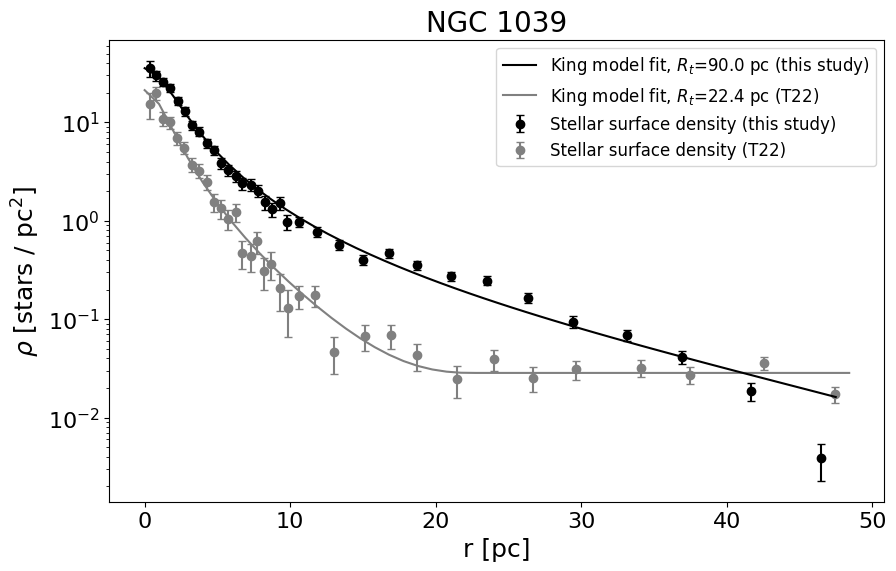

In [31]:
plot_density_profile(member_candidates, cluster, comparison_members,
                     members_label=members_label, comparison_label=comparison_label,
                     title=plot_title)

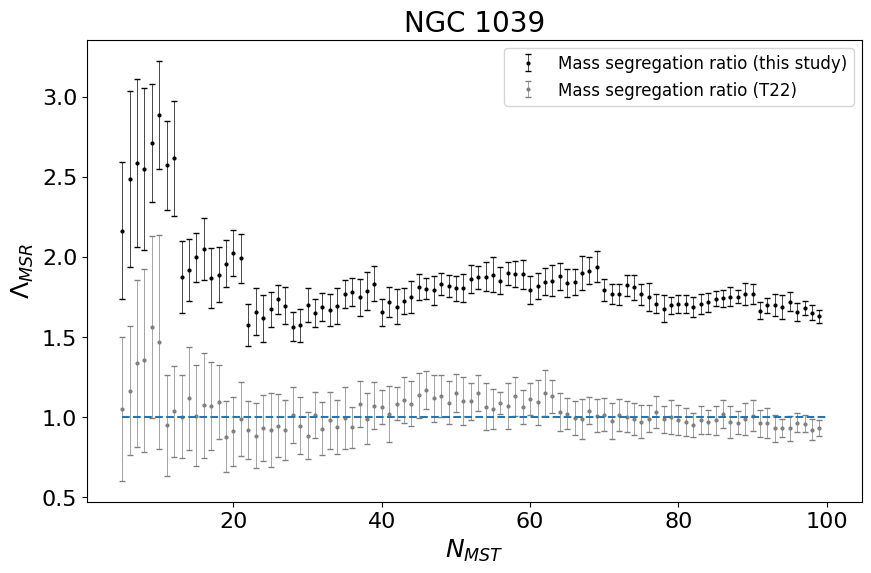

In [32]:
plot_mass_segregation_profile(candidates, cluster, comparison_members,
                              members_label=members_label, comparison_label=comparison_label,
                              title=plot_title)

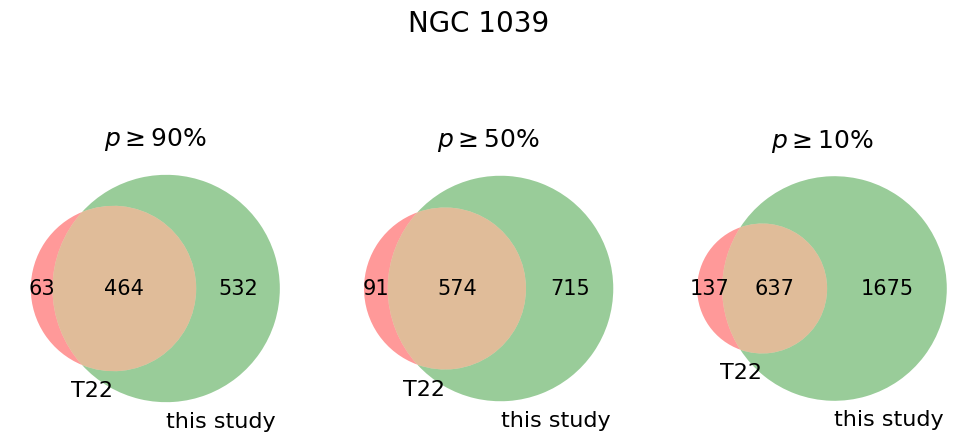

In [33]:
plot_venn_diagram(member_candidates, comparison_members, title=plot_title, 
                  label1=members_label, label2=comparison_label)

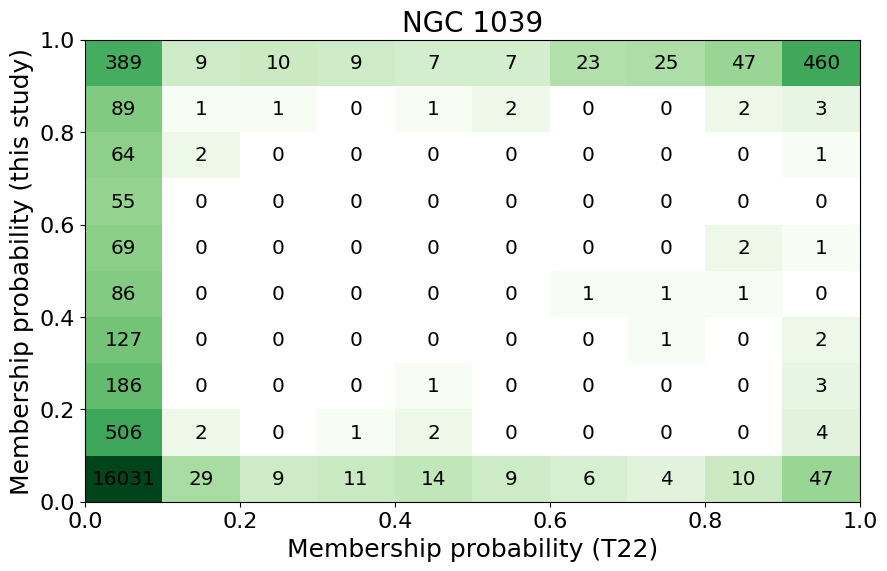

In [34]:
plot_confusion_matrix(candidates, comparison_members, title=plot_title, 
                      label1=members_label, label2=comparison_label)

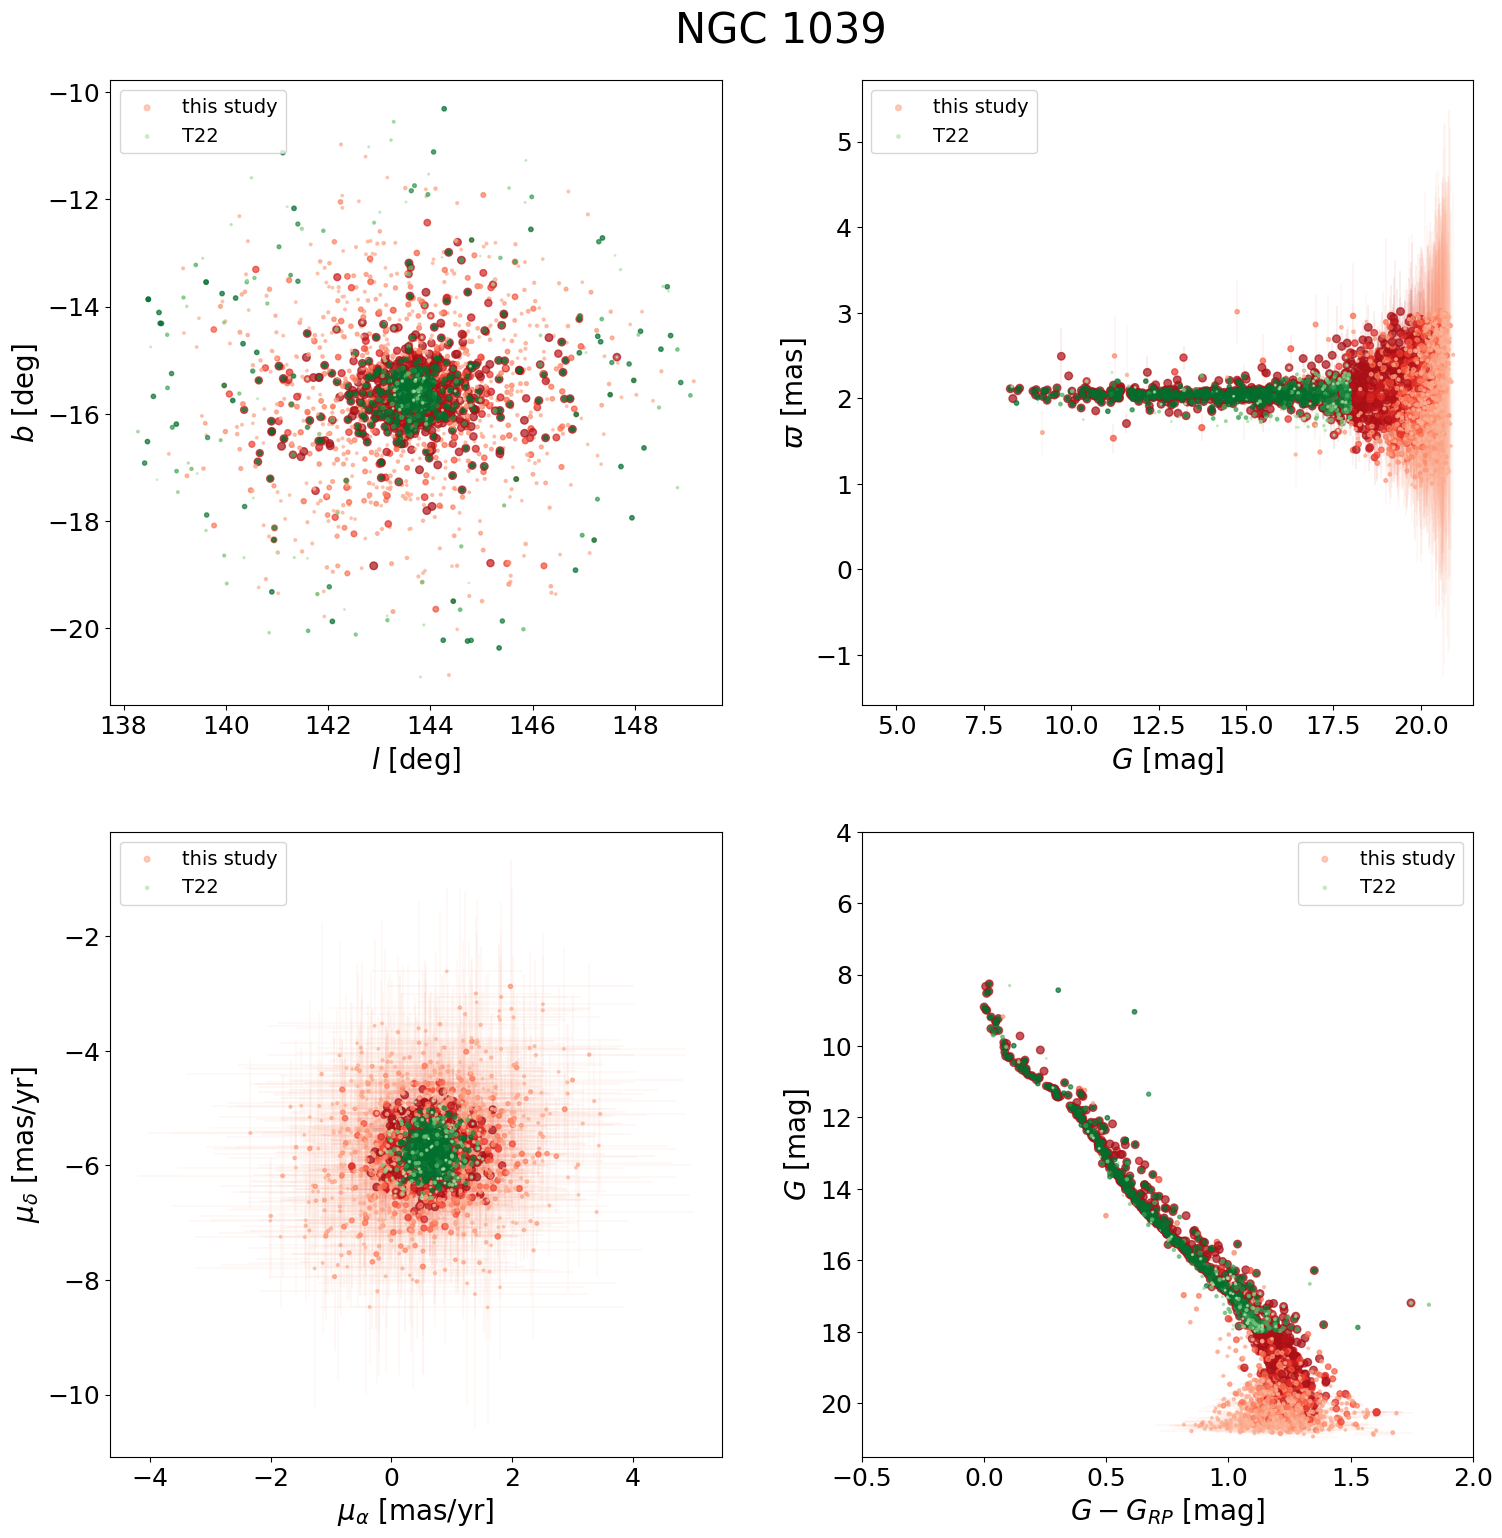

In [35]:
plot_sources(member_candidates, comparison=comparison_members, 
             plot_type='comparison', members_label=members_label,
             comparison_label=comparison_label, title=plot_title, limits=limits)

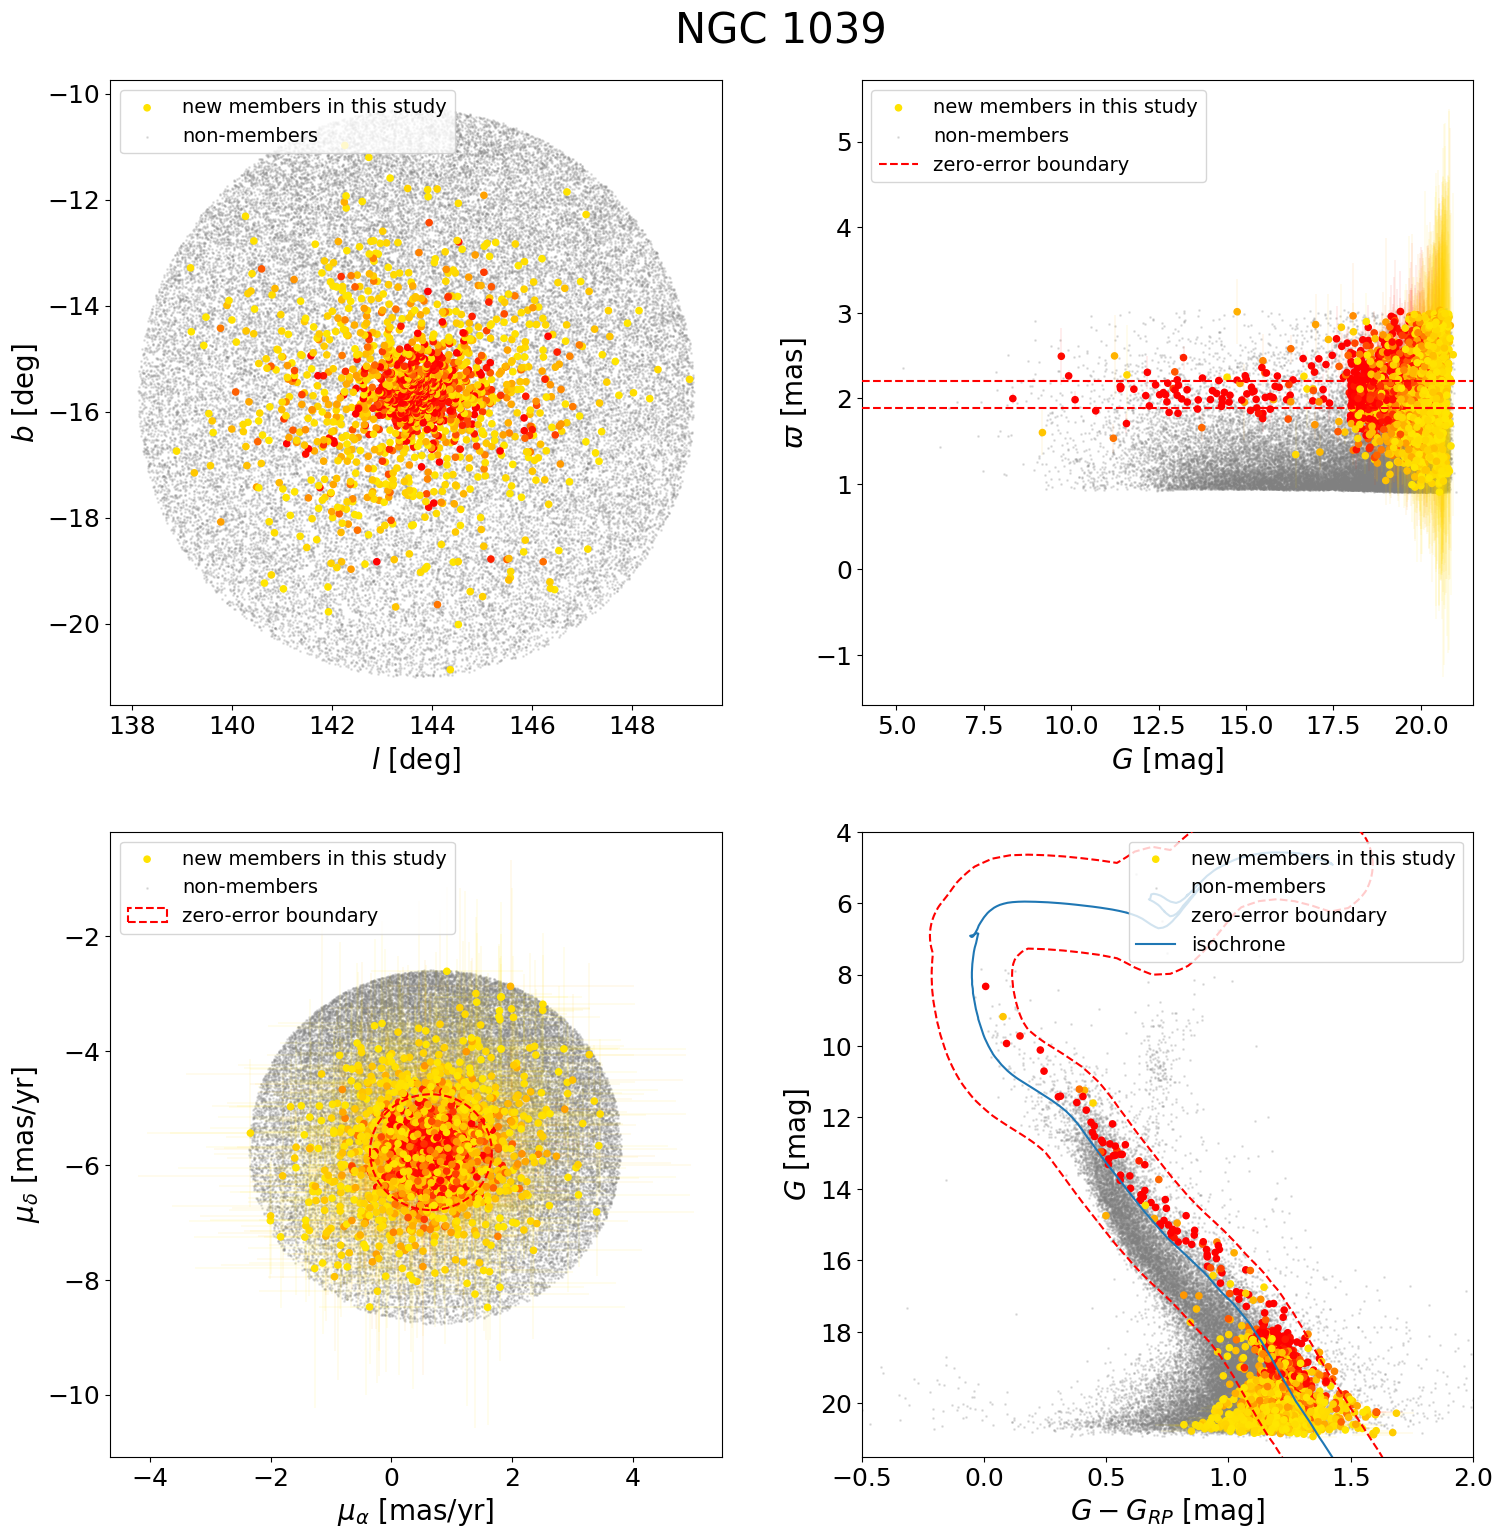

In [36]:
plot_sources(member_candidates, colour='g_rp', comparison=comparison_members, 
             field_sources=non_member_candidates, plot_type='unique_members', 
             members_label='new members in this study', title=plot_title, 
             limits=limits, show_isochrone=True, show_boundaries=True, cluster=cluster)

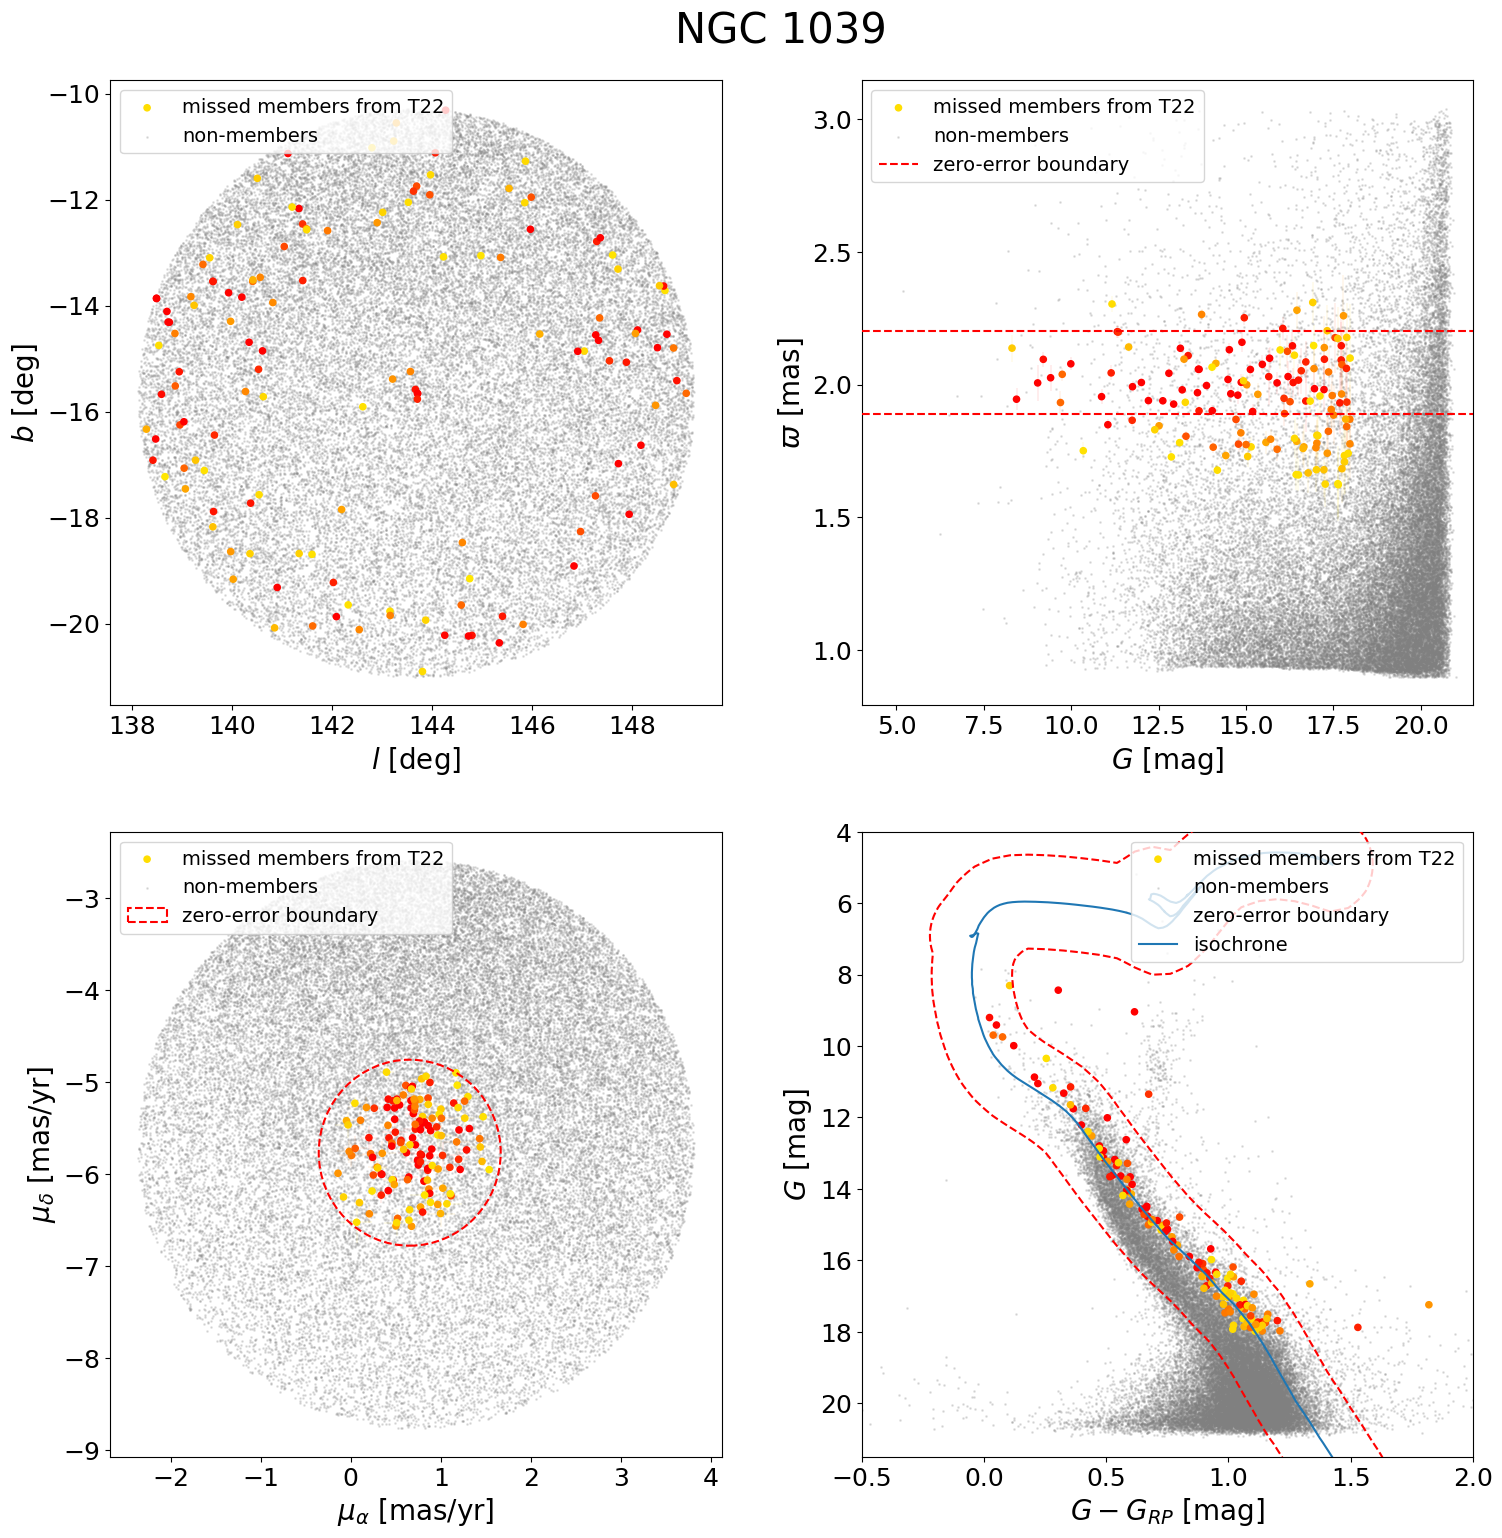

In [37]:
plot_sources(comparison_members, colour='g_rp', comparison=member_candidates, 
             field_sources=non_member_candidates, plot_type='unique_members', 
             members_label='missed members from T22', title=plot_title, 
             limits=limits, show_isochrone=True, show_boundaries=True, cluster=cluster)